In [1]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import collections 
def makehash():
    return collections.defaultdict(makehash)
import fnmatch 
import torch 
from tqdm import tqdm 
from utils import save_dir, analyze_dir, result_dir,train_pool
import scipy.spatial.distance as dist
from tqdm import tqdm
import re
from sklearn.manifold import TSNE

def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    return pd.Series(x).rolling(w, min_periods=w_min).mean()
av_window=10

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [2]:
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier='mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'
#epochs-10_batch-32_lr-0.001_momentum-0.5_init-gaussian_std-0.0001
#                           epochs-10_batch-32_lr-0.002_momentum-0.6_init-gaussian_std-1e-05 \
#                           epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06 

In [4]:
# load training data 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

In [5]:
grad_pkl_files = []
for file in os.listdir(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*gradient_data.pkl'):
        grad_pkl_files.append(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier,file))
s = [re.findall('/\d+', x) for x in grad_pkl_files]
s = [item for sublist in s for item in sublist]
dummy_id = [(x.split('/')) for x in s]
file_id = [int(x.split('/')[1]) for x in s]
sorted_files = [grad_pkl_files[x] for x in np.argsort(file_id)]
grad_pkl_files=sorted_files

In [6]:
g=pickle.load(open(grad_pkl_files[0],'rb'))

In [8]:
e=np.asarray(g['results'][0]['layer_1_Linear']).squeeze()

In [9]:
f=np.mean(e,axis=1)

In [10]:
params = train_pool[model_identifier]()
params.load_dataset()
transfo_mat=params.dataset.transformation_mats

<HDF5 dataset "data": shape (128252,), type "|u1"> is not a matlab type
<HDF5 dataset "ir": shape (128252,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (64128,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
data type not supported: graph, uint32


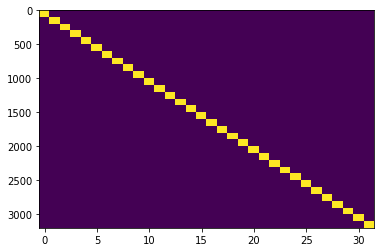

In [11]:
plt.imshow(np.tile(transfo_mat[1],(1,50)).reshape(-1,transfo_mat[1].shape[1]),aspect='auto',interpolation='none')

In [12]:
tiled_transfo_mat=[np.tile(x,(1,50)).reshape(-1,x.shape[1]) for x in transfo_mat]
w=[np.apply_along_axis(np.where,1,x).reshape([-1,1])+1 for x in tiled_transfo_mat]



In [13]:
np.arange(w[0].shape[0])+1

array([   1,    2,    3, ..., 3198, 3199, 3200])

In [14]:
w_fixed=[[(np.arange(w[0].shape[0])+1).reshape(-1,1)],w]
within_class_ids = [item for sublist in w_fixed for item in sublist]
between_class_ids=[within_class_ids[1:],[within_class_ids[0]*0+1]]
between_class_ids = [item for sublist in between_class_ids for item in sublist]

In [9]:
#within_class_ids=[[np.arange(transfo_mat[0].shape[0]).reshape([-1,1])+1],[np.apply_along_axis(np.where,1,x).reshape([-1,1])+1 for x in transfo_mat]]
#within_class_ids = [item for sublist in within_class_ids for item in sublist]
#between_class_ids=[within_class_ids[1:],[within_class_ids[0]*0+1]]
#between_class_ids = [item for sublist in between_class_ids for item in sublist]

In [21]:
withins=[]
betweens=[]
for k in range(len(between_class_ids)):
    temp=np.matmul(within_class_ids[k],within_class_ids[k].transpose())
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),temp.shape[0],axis=0)
    within_class=temp==temp1;
    withins.append(within_class)
    temp=np.matmul(between_class_ids[k],between_class_ids[k].transpose())
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),temp.shape[0],axis=0)
    between_class=temp==temp1;
    betweens.append(between_class)

hier_within_class=[]
hier_between_class=[]
for idx, _ in enumerate(range(len(betweens)-1)):
    A=withins[idx]==(~withins[idx+1])
    hier_within_class.append(A)
    
    B=betweens[idx]==(~betweens[idx+1])
    hier_between_class.append(B)
    
#hier_within_class[0]=np.diagflat(np.ones((1,hier_within_class[0].shape[0])))==1

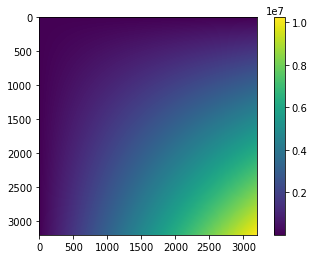

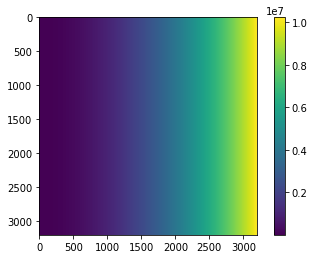

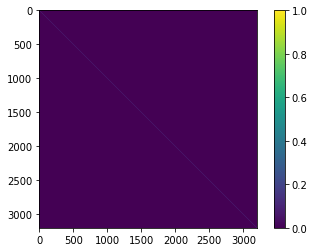

In [22]:
k=0
temp=np.matmul(within_class_ids[k],within_class_ids[k].transpose())
plt.figure()
plt.imshow(temp)
plt.colorbar()
temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),temp.shape[0],axis=0)
plt.figure()
plt.imshow(temp1)
plt.colorbar()

within_class=temp==temp1;

plt.figure()
plt.imshow(within_class)
plt.colorbar()



In [23]:
np.diagflat(np.ones((1,hier_within_class[0].shape[0])))==1


array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

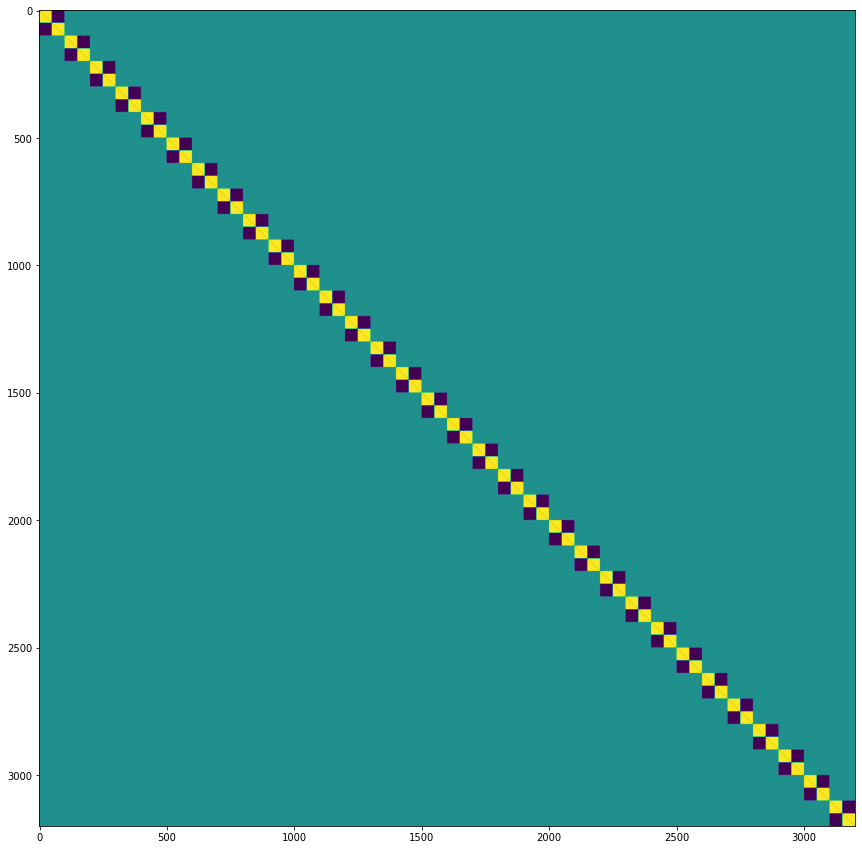

In [24]:
plt.figure(figsize=(15,15))
k=0
plt.imshow(hier_within_class[k].astype(float)-hier_between_class[k].astype(float))

In [25]:
tiled_transfo_mat=[np.tile(x,(1,50)).reshape(-1,x.shape[1]) for x in transfo_mat]
w=[np.apply_along_axis(np.where,1,x).reshape([-1,1])+1 for x in tiled_transfo_mat]
temp=[np.stack([e_f[np.argwhere(y.squeeze()==x),:].squeeze().mean(axis=0) for x in np.unique(y.squeeze())]) for y in w]


NameError: name 'e_f' is not defined

In [26]:
all_grad_within=[]
all_grad_between=[]
all_grad_data=[]
for idx,file in tqdm(enumerate(grad_pkl_files)):
    g=pickle.load(open(file,'rb'))
    e=np.asarray(g['results'][0]['layer_3_Linear']).squeeze()
    all_grad_data.append(e)
    f=np.mean(e,axis=1)
    grad_corr=dist.squareform(dist.pdist(f,'euclidean'))
    grad_within=[grad_corr[x] for x in hier_within_class]
    grad_between=[grad_corr[x] for x in hier_between_class]
    all_grad_within.append(grad_within)
    all_grad_between.append(grad_between)

0it [00:00, ?it/s]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolean dimension is 3200

In [18]:
within_mean=[[np.linalg.norm(y) for y in x] for x in all_grad_within]
between_mean=[[np.linalg.norm(y) for y in x] for x in all_grad_between]

In [17]:
class_norms_l_1=[]
class_norms_l_2=[]
class_norms_l_3=[]
for idx,file in tqdm(enumerate(grad_pkl_files)):
    try:
        g=pickle.load(open(file,'rb'))
        class_norms_l_1.append([np.linalg.norm(np.mean(np.asarray(k['layer_1_Linear']).squeeze(),axis=1),axis=1) for k in g['results']])
        class_norms_l_2.append([np.linalg.norm(np.mean(np.asarray(k['layer_2_Linear']).squeeze(),axis=1),axis=1) for k in g['results']])
        class_norms_l_3.append([np.linalg.norm(np.mean(np.asarray(k['layer_3_Linear']).squeeze(),axis=1),axis=1) for k in g['results']])
    except:
        print(f'cant load{file}')

1060it [00:49, 21.46it/s]


[[<matplotlib.lines.Line2D at 0x2b7a93f6d358>],

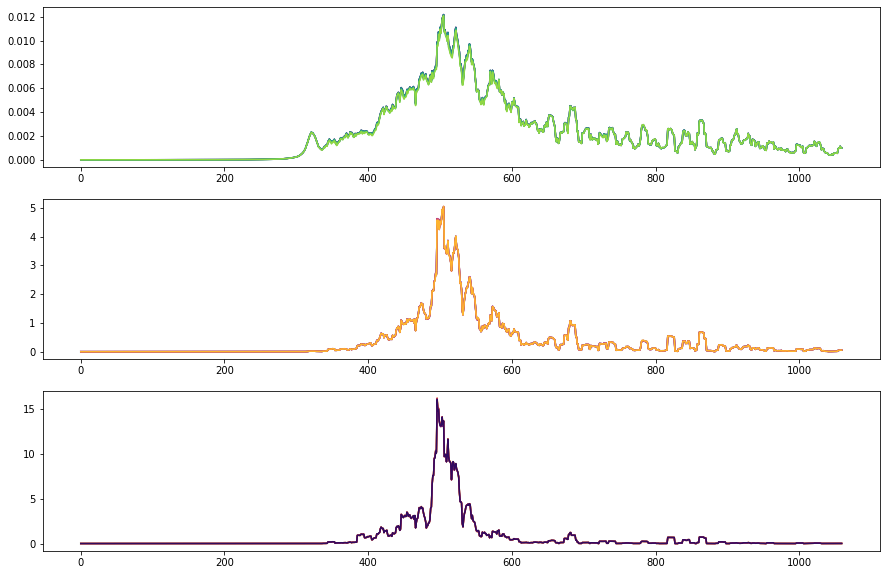

In [24]:
np.stack([[x.mean(axis=0) for x in y] for y in class_norms_l_1])

num_colors=7
h0=cm.get_cmap('viridis_r',num_colors)
l1_line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
h0=cm.get_cmap('plasma_r',num_colors)
l2_line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
h0=cm.get_cmap('inferno',num_colors)
l3_line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
[plt.plot(moving_average(x,10)/len(x),color=l1_line_cols[idx,:]) for idx,x in enumerate(np.stack([[x.mean(axis=0) for x in y] for y in class_norms_l_1]).transpose())]

plt.subplot(3,1,2)
[plt.plot(moving_average(x,10),color=l2_line_cols[idx,:]) for idx,x in enumerate(np.stack([[x.mean(axis=0) for x in y] for y in class_norms_l_2]).transpose())]

plt.subplot(3,1,3)
[plt.plot(moving_average(x,10),color=l3_line_cols[idx,:]) for idx,x in enumerate(np.stack([[x.mean(axis=0) for x in y] for y in class_norms_l_3]).transpose())]


In [119]:
all_grad_within=[]
all_grad_between=[]
all_grad_data=[]
for idx,file in tqdm(enumerate(grad_pkl_files)):
    g=pickle.load(open(file,'rb'))
    e=np.asarray(g['results'][0]['layer_1_Linear']).squeeze()
    all_grad_data.append(e)
    f=np.mean(e,axis=1)
    grad_corr=dist.squareform(dist.pdist(f,'correlation'))
    grad_within=[grad_corr[x] for x in hier_within_class]
    grad_between=[grad_corr[x] for x in hier_between_class]
    all_grad_within.append(grad_within)
    all_grad_between.append(grad_between)

1060it [00:43, 24.34it/s]


In [125]:
e_f=np.reshape(all_grad_data[1],[-1,all_grad_data[1].shape[2]])

In [210]:
e_f.shape

(3200, 624)

In [55]:
within_means=np.stack([[np.linalg.norm(x)/len(x) for x in y] for  y in all_grad_within])
between_means=np.stack([[np.linalg.norm(x)/len(x) for x in y] for  y in all_grad_between])


In [41]:
all_grad_within[0][1]len()

128

[[<matplotlib.lines.Line2D at 0x2b7a99f7b390>],

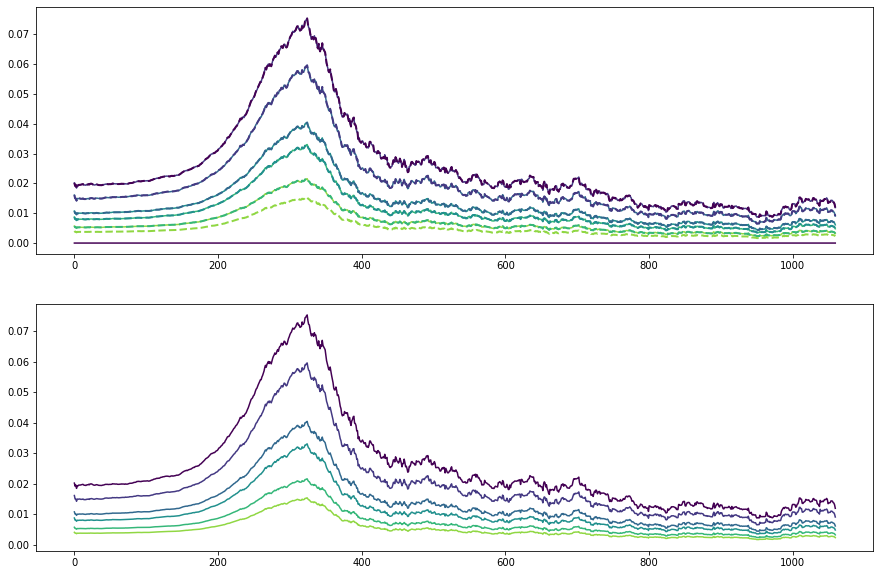

In [58]:
num_colors=7
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
[plt.plot(moving_average(x,50),color=line_cols[idx,:]) for idx,x in enumerate(within_means.transpose())]
[plt.plot(moving_average(x,50),color=line_cols[idx,:],linestyle='--',linewidth=2) for idx,x in enumerate(between_means.transpose())]
plt.subplot(2,1,2)
[plt.plot(moving_average(x,50),color=line_cols[idx,:]) for idx,x in enumerate(between_means.transpose())]

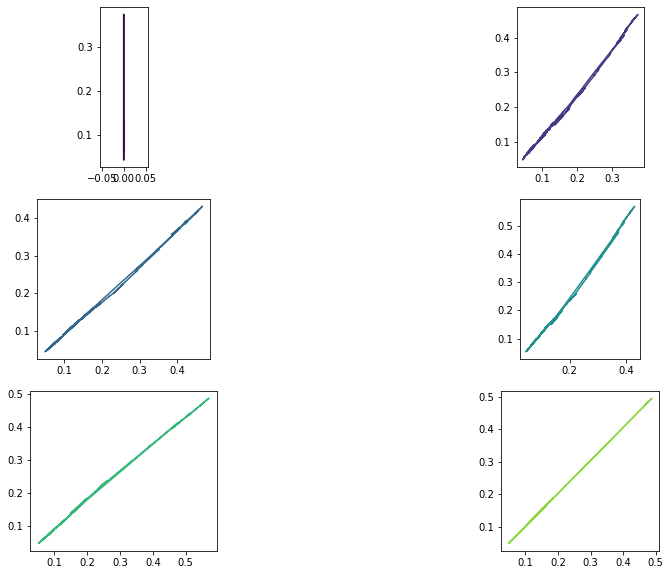

In [321]:
plt.figure(figsize=(15,10))
between_mean_mat=np.stack(between_means).transpose()
within_mean_mat=np.stack(within_means).transpose()

for idx, x in enumerate(within_mean_mat):
    ax=plt.subplot(3,2,idx+1)
    ax.plot(moving_average(x,50),moving_average(between_mean_mat[idx,:],50),color=line_cols[idx,:])
    ax.set_aspect('equal', adjustable='box')
#[plt.plot(moving_average(x,50),moving_average(between_mean_mat[idx,:],50),color=line_cols[idx,:]) for idx,x in enumerate(np.stack(within_mean).transpose())]

#plt.subplot(2,1,2)
#[plt.plot(moving_average(x,50),color=line_cols[idx,:]) for idx,x in enumerate(np.stack(between_mean).transpose())]

# tSNE test

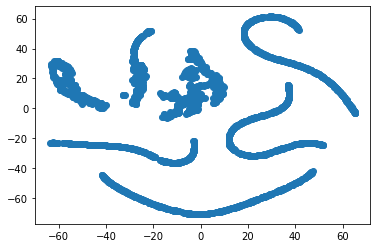

In [85]:
np.concatenate(all_grad_data[0])

array([[ 4.4928120e-11, -3.4012480e-11, -2.9044257e-11, ...,
         4.4644181e-11,  4.4735236e-11,  4.4707588e-11],
       [ 4.5536533e-11, -3.4549079e-11, -2.9571189e-11, ...,
         4.5248756e-11,  4.5341057e-11,  4.5313062e-11],
       [ 4.4936263e-11, -3.4150252e-11, -2.9290119e-11, ...,
         4.4652313e-11,  4.4743365e-11,  4.4715714e-11],
       ...,
       [ 3.6007555e-11, -2.7875237e-11, -2.3708693e-11, ...,
         3.5779997e-11,  3.5852977e-11,  3.5830824e-11],
       [ 3.5491655e-11, -2.7532320e-11, -2.3567112e-11, ...,
         3.5267365e-11,  3.5339297e-11,  3.5317461e-11],
       [ 3.6181995e-11, -2.8073772e-11, -2.4020053e-11, ...,
         3.5953334e-11,  3.6026661e-11,  3.6004404e-11]], dtype=float32)

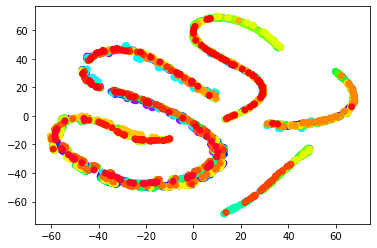

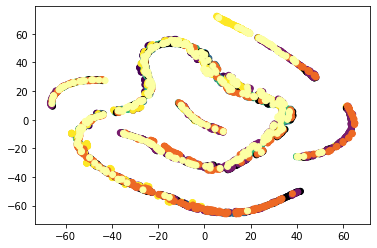

In [116]:
num_colors=8
h0=cm.get_cmap('viridis_r',4)
h1=cm.get_cmap('inferno_r',4)
line_cols_0=np.flipud(h0(np.arange(4)/4))
line_cols_1=np.flipud(h1(np.arange(4)/4))
line_cols=np.concatenate((line_cols_0,line_cols_1))
point_cols=np.repeat(line_cols,400,axis=0)

X_embedded = TSNE(n_components=2).fit_transform(np.concatenate(all_grad_data[500]))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=point_cols)

array([[2.67004e-01, 4.87400e-03, 3.29415e-01, 1.00000e+00],
       [1.90631e-01, 4.07061e-01, 5.56089e-01, 1.00000e+00],
       [2.08030e-01, 7.18701e-01, 4.72873e-01, 1.00000e+00],
       [9.93248e-01, 9.06157e-01, 1.43936e-01, 1.00000e+00],
       [1.46200e-03, 4.66000e-04, 1.38660e-02, 1.00000e+00],
       [4.72328e-01, 1.10547e-01, 4.28334e-01, 1.00000e+00],
       [9.29644e-01, 4.11479e-01, 1.45367e-01, 1.00000e+00],
       [9.88362e-01, 9.98364e-01, 6.44924e-01, 1.00000e+00]])

## Hierarchical accuracies

In [5]:
hier_accu=[]
test_predictions=[]
test_probabilites=[]
test_grad_dict=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
    test_predictions.append([test['target_test'], test['pred_test']])
    test_probabilites.append( test['pred_test_prob'])
    test_grad_dict.append(test['grad_dict'])
    
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

1060it [00:10, 100.24it/s]


In [ ]:
test_grad_dict

In [13]:
np.shape(test_grad_dict[0].keys())

()

In [14]:
test_grad_dict[0].keys()

dict_keys(['fc1', 'fc2', 'fc3'])

In [15]:
test_grad_dict[0]

{'fc1': tensor([[ 8.4226e-07,  3.4296e-08, -1.3944e-06,  ..., -4.2299e-06,
           7.5129e-07, -1.3262e-06],
         [-3.8600e-08, -7.2520e-08, -5.3404e-07,  ...,  6.0660e-08,
           1.8049e-07, -9.4699e-08],
         [-6.8892e-07, -5.3865e-07,  1.2437e-06,  ...,  1.5245e-06,
          -1.4701e-06,  4.4680e-07],
         ...,
         [ 5.5795e-07,  4.3709e-07, -3.5832e-06,  ..., -5.9519e-07,
           2.0748e-06, -1.6553e-06],
         [ 7.2360e-07,  5.3375e-07, -8.1154e-07,  ...,  7.4945e-07,
           1.2812e-06,  1.0178e-06],
         [ 1.1090e-06, -1.7366e-07, -3.2942e-08,  ...,  2.0232e-06,
          -1.4563e-06,  1.3492e-06]]),
 'fc2': tensor([[ 1.8736e-06,  8.2307e-07, -8.2114e-07,  ...,  1.1438e-06,
           1.2960e-06, -6.1955e-07],
         [ 9.3352e-06,  1.5680e-06,  3.7186e-09,  ...,  2.2615e-06,
           1.2269e-06,  3.0182e-06],
         [ 6.5354e-06,  3.0684e-07,  8.7925e-07,  ..., -1.4762e-07,
           3.0054e-06, -5.6595e-07],
         ...,
         [-

In [18]:
test_grad_dict[0]['fc1']

tensor([[ 8.4226e-07,  3.4296e-08, -1.3944e-06,  ..., -4.2299e-06,
          7.5129e-07, -1.3262e-06],
        [-3.8600e-08, -7.2520e-08, -5.3404e-07,  ...,  6.0660e-08,
          1.8049e-07, -9.4699e-08],
        [-6.8892e-07, -5.3865e-07,  1.2437e-06,  ...,  1.5245e-06,
         -1.4701e-06,  4.4680e-07],
        ...,
        [ 5.5795e-07,  4.3709e-07, -3.5832e-06,  ..., -5.9519e-07,
          2.0748e-06, -1.6553e-06],
        [ 7.2360e-07,  5.3375e-07, -8.1154e-07,  ...,  7.4945e-07,
          1.2812e-06,  1.0178e-06],
        [ 1.1090e-06, -1.7366e-07, -3.2942e-08,  ...,  2.0232e-06,
         -1.4563e-06,  1.3492e-06]])

In [19]:
np.shape(test_grad_dict[0]['fc1'])

torch.Size([624, 936])

In [7]:
hier_accu=[hier_accu[x] for x in fixed_idx]
accuracies=np.stack([x[2] for x in hier_accu])
batches=np.stack([x[1] for x in hier_accu])
epochs=np.stack([x[0] for x in hier_accu])

In [11]:
# load distance data (have to run it first)
data_=pickle.load(open(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier, f'{model_identifier}_distance_pooled.pkl'),'rb'))

# fix any ordering issue 
layer_dist_over_time=[]
epoch_over_time=[]
batch_idx_over_time=[]
for layer in data_['distance_results'].keys():
    hier_distance_over_time=[]
    for hier in data_['distance_results'][layer].keys():
        distance_over_time=[]
        if hier!='epoch':
            for key,item in data_['distance_results'][layer][hier].items():
                distance_over_time.append(item['distance'].mean(axis=1))
            hier_distance_over_time.append(dict(data=np.stack(distance_over_time),id=item['identifier']))
    layer_dist_over_time.append(hier_distance_over_time)

In [20]:
data_=pickle.load(open(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier, f'{model_identifier}_gradient_data.pkl'),'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/extracted/mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5/NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed/epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06/NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed_gradient_data.pkl'

In [12]:
seq_keys=list(data_['distance_results']['layer_0_Input'][0].keys())
seq_keys=[x for x in seq_keys if x!='epoch' ]
dist_epochs=[data_['distance_results']['layer_0_Input'][0][x]['epoch'] for x in seq_keys]
dist_batch=[data_['distance_results']['layer_0_Input'][1][x]['batchidx'] for x in seq_keys]

Get epoch numbering for axes

In [13]:
epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*epochs+batches
dist_epoch_batch=epoch_factor*np.array(dist_epochs)+np.array(dist_batch)
array_correspondance=[np.argwhere(x==epoch_batch) for x in dist_epoch_batch]

In [14]:
x_bar= np.arange(len(epoch_batch))/len(epoch_batch)
epoch_bar=np.argwhere(np.diff(dist_epochs))/(len(dist_epochs))
epoch_bar

array([[0.0990566],
       [0.1990566],
       [0.2990566],
       [0.3990566],
       [0.4990566],
       [0.5990566],
       [0.6990566],
       [0.7990566],
       [0.8990566]])

## Do gradient analysis

In [15]:
fc1_grad=[x['fc1'] for x in test_grad_dict]
fc2_grad=[x['fc2'] for x in test_grad_dict]
fc3_grad=[x['fc3'] for x in test_grad_dict]

In [16]:
len(fc1_grad) # no time points

1060

In [17]:
np.shape(fc1_grad[0])

torch.Size([624, 936])

In [18]:
print(len(fc1_grad[0][1]))

936


In [19]:
len(x_bar)

1060

In [20]:
# compute matrix L2 frob norm 
grad1 = [np.linalg.norm(x) for x in fc1_grad]
grad2 = [np.linalg.norm(x) for x in fc2_grad]
grad3 = [np.linalg.norm(x) for x in fc3_grad]

np.shape(grad1)

(1060,)

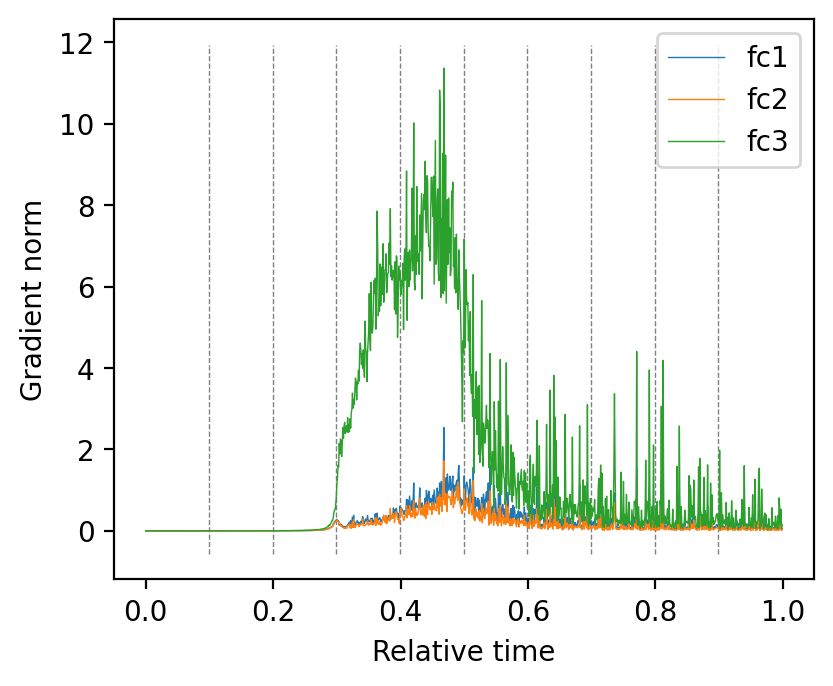

In [23]:
fig=plt.figure(1,figsize=(10,14),dpi=200,frameon=False)
ax=plt.axes((.05,.7,.35,.2))
ax.plot(x_bar, grad1, label='fc1', linewidth=0.5)
ax.plot(x_bar, grad2, label='fc2', linewidth=0.5)
ax.plot(x_bar, grad3, label='fc3', linewidth=0.5)
ax.set_xlabel('Relative time')
ax.set_ylabel('Gradient norm')
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.legend()


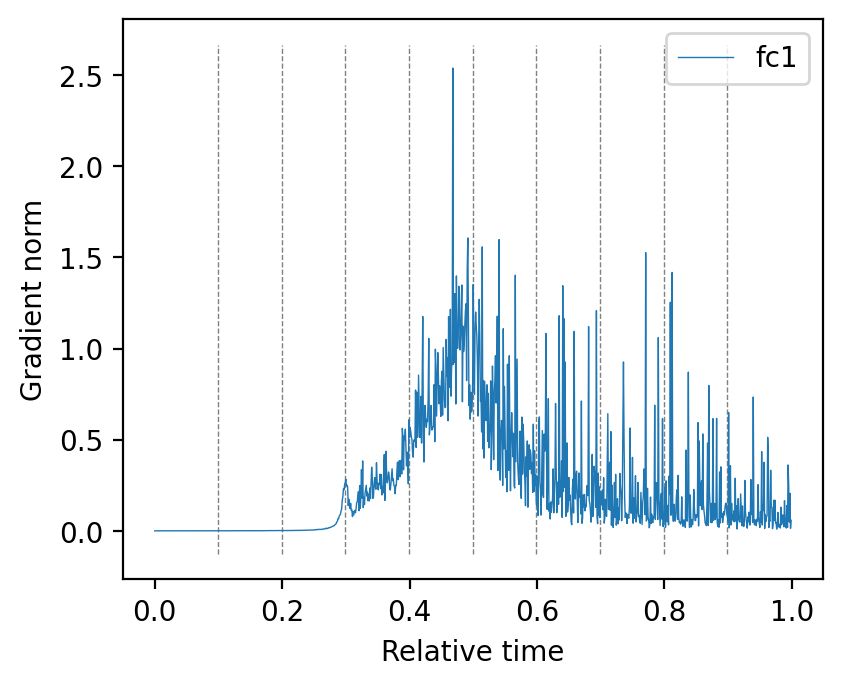

In [24]:
fig=plt.figure(1,figsize=(10,14),dpi=200,frameon=False)
ax=plt.axes((.05,.7,.35,.2))
ax.plot(x_bar, grad1, label='fc1', linewidth=0.5)
ax.set_xlabel('Relative time')
ax.set_ylabel('Gradient norm')
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.legend()

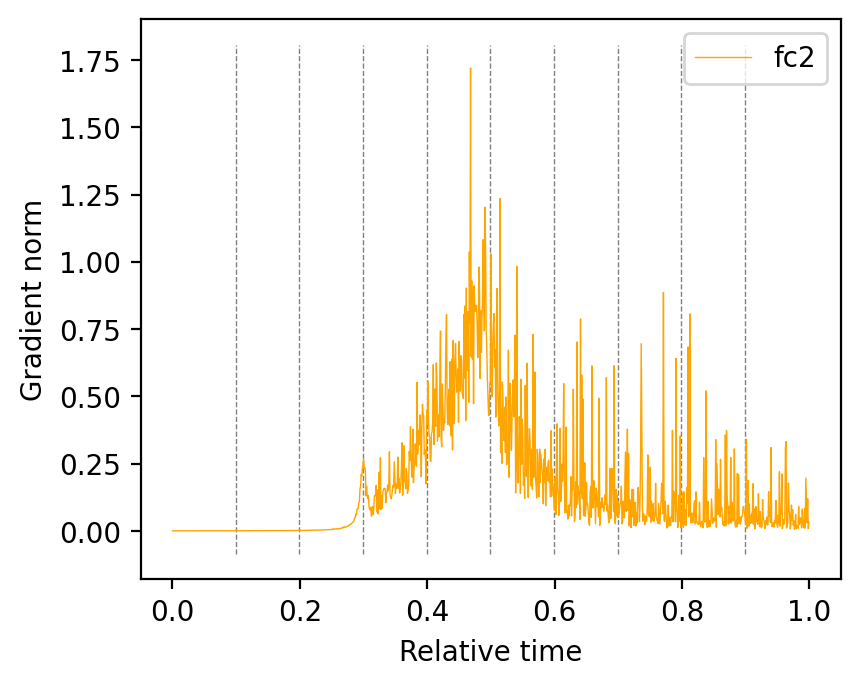

In [27]:
fig=plt.figure(1,figsize=(10,14),dpi=200,frameon=False)
ax=plt.axes((.05,.7,.35,.2))
ax.plot(x_bar, grad2, label='fc2', linewidth=0.5,color='orange')
ax.set_xlabel('Relative time')
ax.set_ylabel('Gradient norm')
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.legend()

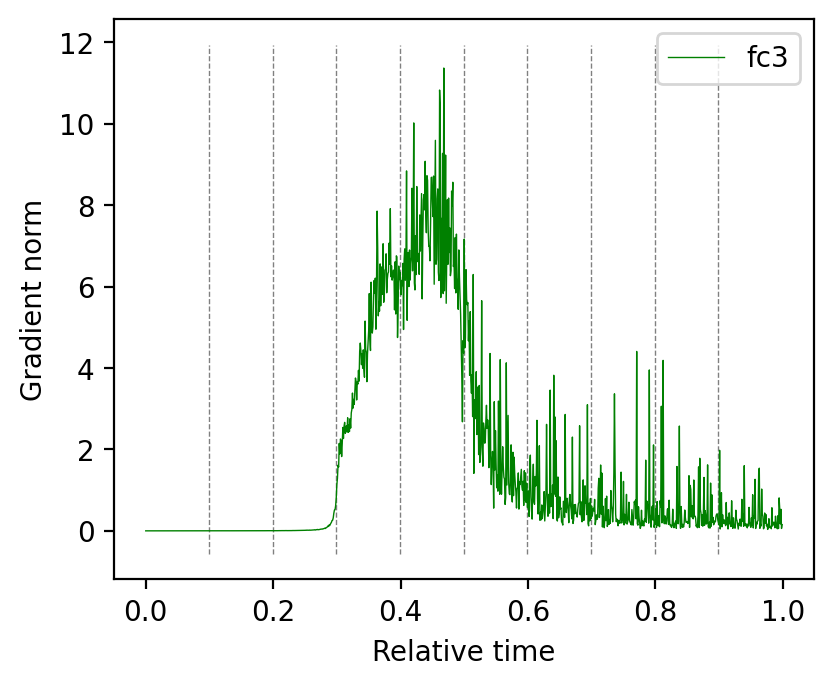

In [26]:
fig=plt.figure(1,figsize=(10,14),dpi=200,frameon=False)
ax=plt.axes((.05,.7,.35,.2))
ax.plot(x_bar, grad3, label='fc3', linewidth=0.5,color='green')
ax.set_xlabel('Relative time')
ax.set_ylabel('Gradient norm')
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.legend()

## create figure 2

/om/user/gretatu/.conda/envs/brainmodeling/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


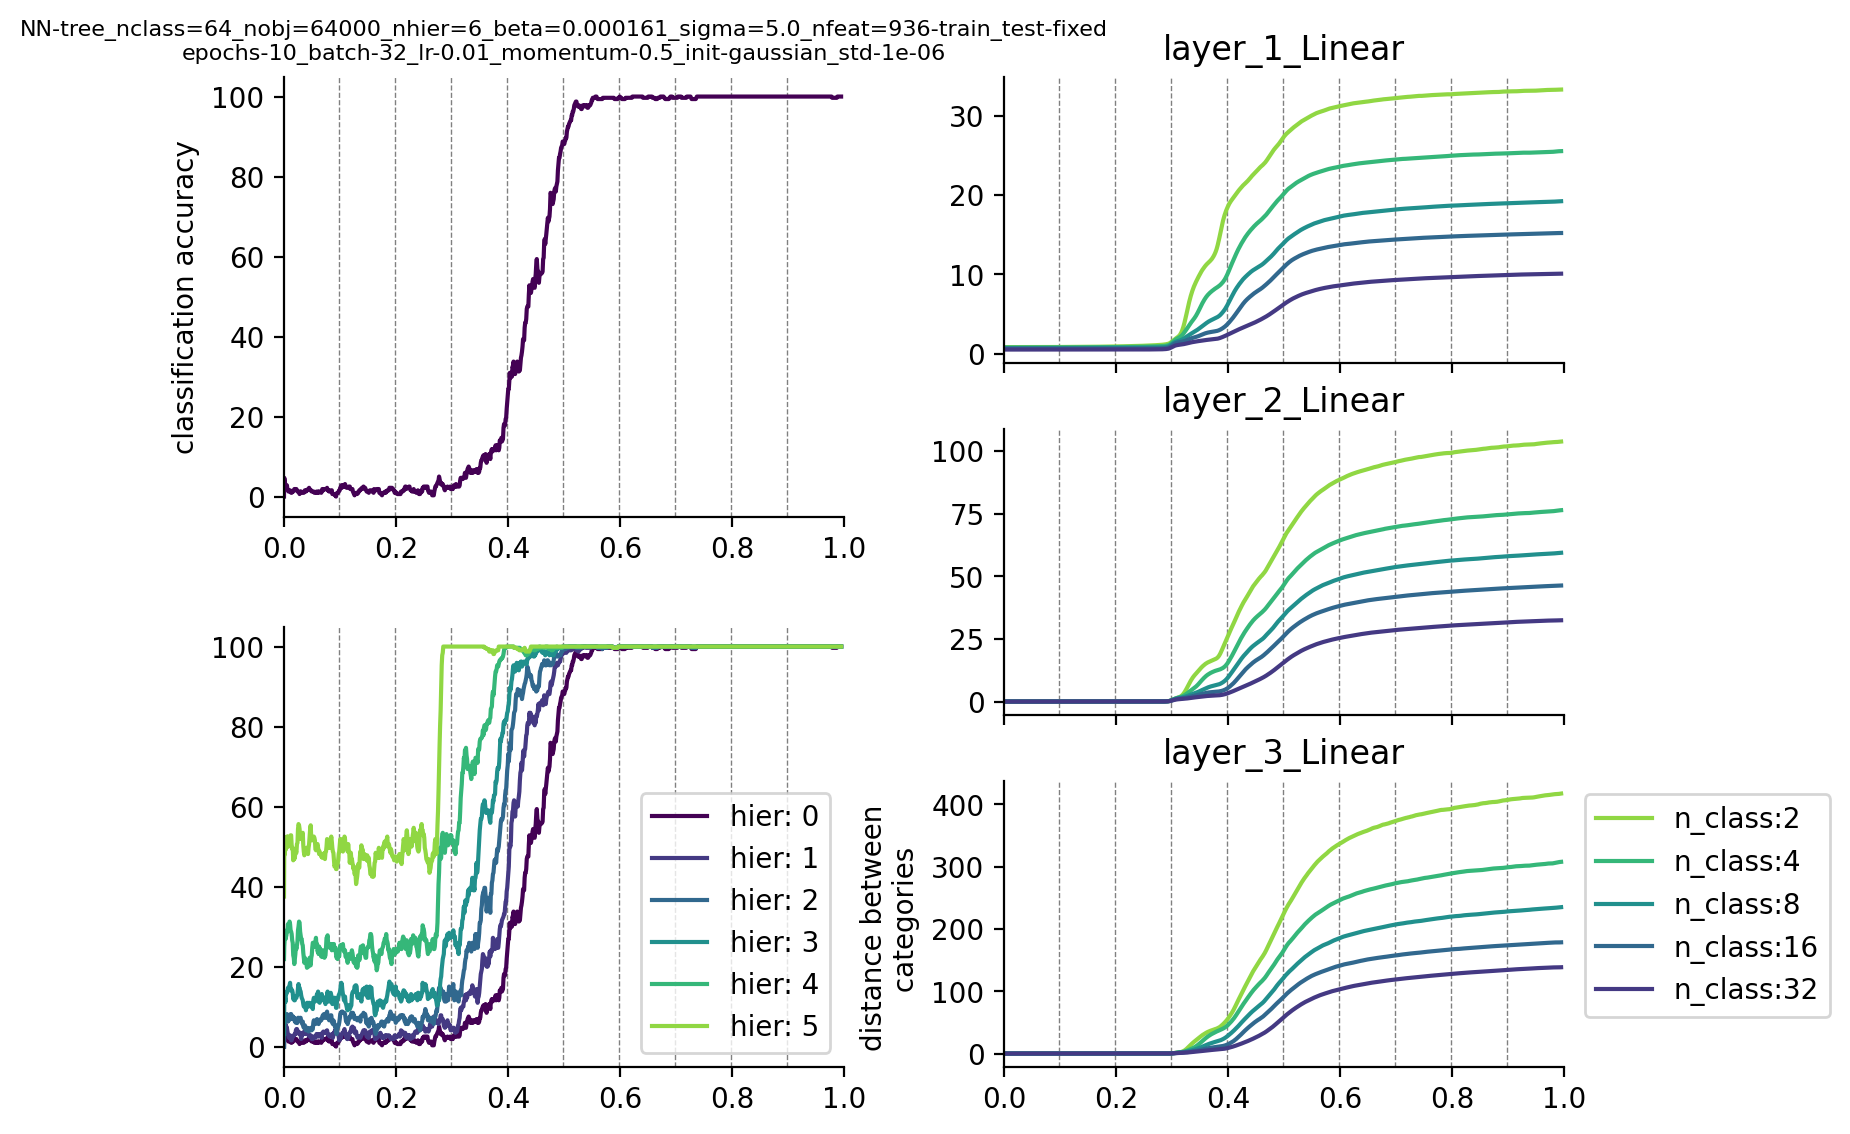

In [22]:
xmin=0
xmax=1
num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))


fig=plt.figure(1,figsize=(8,11),dpi=200,frameon=False)
ax1=plt.axes((.05,.7,.35,.2))
ax1.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,0],av_window),label='entities',color=line_cols[0,:])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel('classification accuracy')
ax1.set_title(f"{model_identifier}\n{train_identifier}",fontsize=8)
ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.autoscale(enable=True, axis='y', tight=True)
ax1.set_xlim((xmin,xmax))

ax2=plt.axes((.05,.45,.35,.2))
for h in range(accuracies.shape[1]):
        ax2.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,h],av_window),label=f'hier: {h}',color=line_cols[h,:])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
ax2.vlines(epoch_bar,ax2.get_ylim()[0],ax2.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.autoscale(enable=True, axis='y', tight=True)
ax2.set_xlim((xmin,xmax))
# layer 1. 


ax3=plt.axes((.5,.77,.35,.13))
k=1
layer_data=layer_dist_over_time[k]
for h, hier_data in enumerate(layer_data):
    distance_data=hier_data['data'].mean(axis=1)
    corrected_data=list(np.empty(epoch_batch.shape)*np.NaN)
    for idx, x in enumerate(array_correspondance):
        corrected_data[int(x)]=distance_data[idx]

    #ax3.plot(corrected_data,label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
    ax3.plot(moving_average(x_bar,av_window),moving_average(corrected_data,av_window),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
ax3.set_title(f"{list(data_['distance_results'].keys())[k]}")

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.axes.xaxis.set_ticklabels([])
ax3.vlines(epoch_bar,ax3.get_ylim()[0],ax3.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax3.autoscale(enable=True, axis='x', tight=True)
ax3.autoscale(enable=True, axis='y', tight=True)
ax3.set_xlim((xmin,xmax))

# layer 2. 
ax4=plt.axes((.5,.61,.35,.13))
k=2
layer_data=layer_dist_over_time[k]
for h, hier_data in enumerate(layer_data):
    distance_data=hier_data['data'].mean(axis=1)
    corrected_data=list(np.empty(epoch_batch.shape)*np.NaN)
    for idx, x in enumerate(array_correspondance):
        corrected_data[int(x)]=distance_data[idx]

    #ax4.plot(hier_data['data'].mean(axis=1),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
    ax4.plot(moving_average(x_bar,av_window),moving_average(corrected_data,av_window),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
ax4.set_title(f"{list(data_['distance_results'].keys())[k]}")
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.axes.xaxis.set_ticklabels([])
ax4.vlines(epoch_bar,ax4.get_ylim()[0],ax4.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax4.autoscale(enable=True, axis='x', tight=True)
ax4.autoscale(enable=True, axis='y', tight=True)
ax4.set_xlim((xmin,xmax))
# layer 3. 
ax5=plt.axes((.5,.45,.35,.13))
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

k=3
layer_data=layer_dist_over_time[k]
for h, hier_data in enumerate(layer_data):
    distance_data=hier_data['data'].mean(axis=1)
    corrected_data=list(np.empty(epoch_batch.shape)*np.NaN)
    for idx, x in enumerate(array_correspondance):
        corrected_data[int(x)]=distance_data[idx]

    #ax5.plot(hier_data['data'].mean(axis=1),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
    ax5.plot(moving_average(x_bar,av_window),moving_average(corrected_data,av_window),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
ax5.set_title(f"{list(data_['distance_results'].keys())[k]}")
ax5.legend(bbox_to_anchor=(1, .5, 0.5, 0.5))
ax5.set_ylabel('distance between \n categories')
ax5.vlines(epoch_bar,ax5.get_ylim()[0],ax5.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax5.autoscale(enable=True, axis='x', tight=True)
ax5.autoscale(enable=True, axis='y', tight=True)
ax5.set_xlim((xmin,xmax))

plt.tight_layout()
plt.show()


# plot hierarchical variance 

In [52]:

#model_identifier = args.model_identifier
params = train_pool[model_identifier]()
params.load_dataset()
transfo_mat=params.dataset.transformation_mats
hier_probs = [[np.matmul(x, hier) for hier in transfo_mat] for x in test_probabilites]
hier_pred=[[torch.tensor(x).argmax(dim=1,keepdim=True) for x in y] for y in hier_probs]
hier_pred_var=np.array([[np.std(y.numpy()) for y in x] for x in hier_pred])

<HDF5 dataset "data": shape (128252,), type "|u1"> is not a matlab type
<HDF5 dataset "ir": shape (128252,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (64128,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
data type not supported: graph, uint32


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


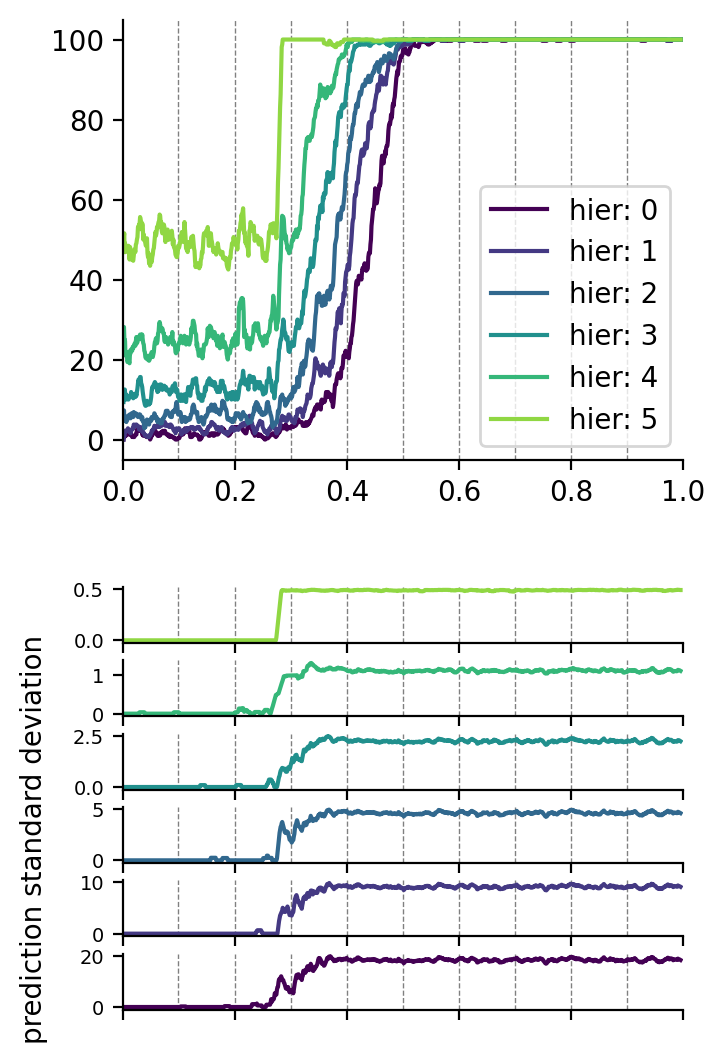

In [61]:
xmin=0
xmax=1
num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))


fig=plt.figure(1,figsize=(8,11),dpi=200,frameon=False)
ax1=plt.axes((.05,.7,.35,.2))
#ax1.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,0],av_window),label='entities',color=line_cols[0,:])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#ax1.set_ylabel('classification accuracy')
#ax1.set_title(f"{model_identifier}\n{train_identifier}",fontsize=8)
#ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
#ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.autoscale(enable=True, axis='y', tight=True)
#ax1.set_xlim((xmin,xmax))

#ax2=plt.axes((.05,.45,.35,.2))
ax2=plt.axes((.05,.7,.35,.2))
for h in range(accuracies.shape[1]):
        ax2.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,h],av_window),label=f'hier: {h}',color=line_cols[h,:])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
ax2.vlines(epoch_bar,ax2.get_ylim()[0],ax2.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.autoscale(enable=True, axis='y', tight=True)
ax2.set_xlim((xmin,xmax))


axis_split=accuracies.shape[1]

for h in range(accuracies.shape[1]):
    ax2=plt.axes((.05,.45+h*.2/axis_split,.35,.2/axis_split-0.008))


    ax2.plot(moving_average(x_bar,av_window),moving_average(hier_pred_var[:,h],av_window),label=f'hier: {h}',color=line_cols[h,:])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.axes.xaxis.set_ticklabels([])
    #ax2.axes.yaxis.set_ticklabels([])
    #ax2.axes.yaxis.set_ticklabels(ax2.get_ticklabels())
    plt.setp(ax2.get_yticklabels(), fontsize=7)
#ax2.legend()
    ax2.vlines(epoch_bar,ax2.get_ylim()[0],ax2.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
    ax2.autoscale(enable=True, axis='x', tight=True)
    ax2.autoscale(enable=True, axis='y', tight=True)
    ax2.set_xlim((xmin,xmax))
    if h==2:
        ax2.set_ylabel('prediction standard deviation \n')

# gradient norms 

In [32]:
all_grad=np.stack([[np.linalg.norm(x[y]) for y in x.keys()]for x in test_grad_dict])



In [48]:
all_grad_names=([[y for y in x.keys()]for x in test_grad_dict])
all_grad_names=all_grad_names[0]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


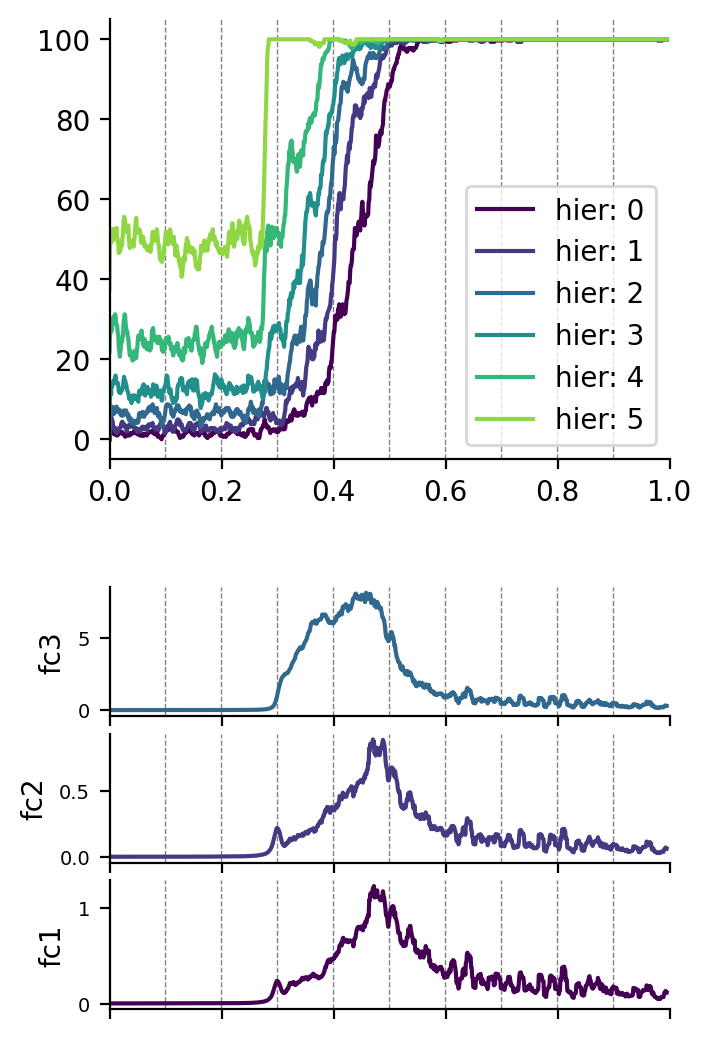

In [51]:
xmin=0
xmax=1
num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))


fig=plt.figure(1,figsize=(8,11),dpi=200,frameon=False)
ax1=plt.axes((.05,.7,.35,.2))
#ax1.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,0],av_window),label='entities',color=line_cols[0,:])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#ax1.set_ylabel('classification accuracy')
#ax1.set_title(f"{model_identifier}\n{train_identifier}",fontsize=8)
#ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
#ax1.autoscale(enable=True, axis='x', tight=True)
#ax1.autoscale(enable=True, axis='y', tight=True)
#ax1.set_xlim((xmin,xmax))

#ax2=plt.axes((.05,.45,.35,.2))
ax2=plt.axes((.05,.7,.35,.2))
for h in range(accuracies.shape[1]):
        ax2.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,h],av_window),label=f'hier: {h}',color=line_cols[h,:])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
ax2.vlines(epoch_bar,ax2.get_ylim()[0],ax2.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.autoscale(enable=True, axis='y', tight=True)
ax2.set_xlim((xmin,xmax))


axis_split=accuracies.shape[1]

for h in range(all_grad.shape[1]):
    ax2=plt.axes((.05,.45+h*.4/axis_split,.35,.4/axis_split-0.008))


    ax2.plot(moving_average(x_bar,av_window),moving_average(all_grad[:,h],av_window),label=f'hier: {h}',color=line_cols[h,:])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.axes.xaxis.set_ticklabels([])
    ax2.set_ylabel(all_grad_names[h])
    #ax2.axes.yaxis.set_ticklabels([])
    #ax2.axes.yaxis.set_ticklabels(ax2.get_ticklabels())
    plt.setp(ax2.get_yticklabels(), fontsize=7)
#ax2.legend()
    ax2.vlines(epoch_bar,ax2.get_ylim()[0],ax2.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
    ax2.autoscale(enable=True, axis='x', tight=True)
    ax2.autoscale(enable=True, axis='y', tight=True)
    ax2.set_xlim((xmin,xmax))
